# Домашняя работа 5. Бустинг

*Мягкий дедлайн: 17 декабря, 21:00*

*Жесткий дедлайн: 19 декабря, 21:00*


Максимальная оценка 5 баллов :)

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston # sorry(not sorry)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
from scipy.optimize import minimize

### Задание 1. Градиентный бустинг своими руками  (2 балла)

Вам нужно реализовать упрощенный вариант градиентного бутсинга для задачи регресси. 


**Напоминание, как это работает:**

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается так:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu \in [0, 1]$ — темп обучения (гиперпараметр), $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма в ходе решения оптимизационной задачи:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$


Заметьте, что в формуле выше нет $\nu$. Этот гиперпараметр используется для сокращения длины шага, оптимального при составлении композиции $a_N$. Идея отклонения от оптимума должна быть вам уже знакома как способ борьбы с переобучением, когда мы специально форсим модель работать чуть хуже, чем могла бы, на текущем шаге, чтобы сохранить обобщающую способность и не подогнаться под тренировочную выборку (или под шум).

С потерей в 0.5 балла можете принять $\gamma_N = 1$ для каждого $N$. На полный балл необходимо реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь $L$ возьмите MSE.

В качестве базовой модели можете использовать `DecisionTreeRegressor` из `sklearn`.
Для решения оптимизационной задачки можно воспользоваться алгоритмами из любых библиотек, например, `scipy.optimize`, или найти оптимум перебором по сетке из некоторого разумного диапазона.

Можно дописывать свои функции, если необходимо.

In [356]:
class GradientBoosting:
    def __init__(
        self, 
        base_model_class: object = DecisionTreeRegressor,
        base_model_params: dict = {'max_depth': None},
        n_estimators: int = 10,
        learning_rate: float = 0.1
    ):
        """
        
        Args:
          base_model_class: Class of the base learner.

          base_model_params: Hyperparameters of the base learner.
          
          n_estimators: Number of boosting stages.
          
          learning_rate: Value used to shrink contribution of each base learner to the model. 
          
        """
        
        self.base_model_class = base_model_class
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
        self.base_model_params = base_model_params
        
        # list for optimal gammas at each iteration
        self.gammas = []
        
        # list for base models
        self.models = []
        
        # list for error tracking
        self.errors = []
          
    
    def find_optimal_gamma(self, 
                           y: np.array, 
                           old_predictions: np.array,
                           new_predictions: np.array) -> float:
        """You may add arguments if it's necessary for your optimization algorithm.
        
        Args:
          y: Target variable.

          old_predictions: Prediction of the additive model at the previous stage.
          
          new_predictions: Prediction of the base learner at the current stage. 
          
        Returns:
          Optimal value for gamma.
          
        """
        optimal_gamma = minimize(lambda gamma: np.sum((y - old_predictions - gamma*new_predictions)**2), x0 = 1).x[0]
        self.gammas.append(optimal_gamma)
    
    
    def _fit_base_model(self, X: np.ndarray, y: np.array):
        """Train one base learner. 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted base learner.
          
        """
        base_model = DecisionTreeRegressor()
        base_model.set_params(**self.base_model_params)
        base_model.fit(X, y)
        self.models.append(base_model)
        return base_model
    
        
    def fit(self, X: np.ndarray, y: np.array):
        """Train boosting ("sum" of base learners). 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted boosting.
          
        """
        
        for i in range(self.n_estimators):
            if len(self.models) == 0:
                    self.models.append(np.zeros(X.shape[0]))
                    self.gammas.append(1)
            else:
                s = 2*(y-self.predict(X))/len(X)
                old_predictions = self.predict(X)
                model = self._fit_base_model(X, s)
                
                self.find_optimal_gamma(y, old_predictions, model.predict(X))
            if i % 2 == 0:
                self.errors.append(mean_squared_error(y, self.predict(X)))
        return self
       
        
    def predict(self, X: np.ndarray):
        """Make prediction of fitted boosting. 
        
        Args:
          X: Feature matrix


        Returns:
          Prediction of fitted boosting.
          
        """
        if len(self.models) > 0:
            y_predicted = np.zeros(X.shape[0])
            for i, base_model in enumerate(self.models[1:]):
                y_predicted += self.learning_rate*self.gammas[i]*base_model.predict(X)
            return y_predicted
            

Проверьте вашу реализацию на бостонском датасете. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor (не меняйте параметры сида).

In [201]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [202]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

Попробуем запустить `Gradient Boosting` с дефолтными параметрами. Зафисксируем случайный seed для воспроизводимости результатов.

In [315]:
%%time

gb = GradientBoosting(base_model_params={"random_state" : 42})
gb.fit(X_train, y_train)
print(f"MSE of this model is {mean_squared_error(y_test, gb.predict(X_test))}")

MSE of this model is 121.41628142959033
Wall time: 61.9 ms


Видно, что разница очень велика. Попробуем подобрать по сетке гиперпараметры:

In [347]:
%%time
params = {
    "n_estimators" : np.arange(10, 60, 2),
    "learning_rate" : np.arange(0.1, 0.25, 0.025),
    "max_depth" : np.arange(1, 7),
    "min_samples_leaf" : np.arange(2, 5),
    "max_features" : np.arange(1, 5)
}
keys = list(params.keys())
combinations = np.array(np.meshgrid(*list(params.values()))).T.reshape(-1,5)
best_MSE = None
best_params = None
for i in combinations:
    base_model_params = dict(zip(keys[2:], i[2:].astype(int)))
    base_model_params["random_state"] = 42
    gb = GradientBoosting(n_estimators=int(i[0]), learning_rate=i[1], base_model_params=base_model_params)
    gb.fit(X_train, y_train)
    mse = mean_squared_error(y_test, gb.predict(X_test))
    if best_MSE is None:
        best_MSE = mse
        best_params = i
    if mse < best_MSE:
        best_MSE = mse
        best_params = i

Wall time: 41min 39s


Параметры и скор лучшей модели:

In [353]:
print("Parameters of the best model:")
for i, key in enumerate(keys):
    print(f"\t{key} : {best_params[i]}")
print(f"MSE of the best model is {best_MSE}")

Parameters of the best model:
	n_estimators : 58.0
	learning_rate : 0.15
	max_depth : 6.0
	min_samples_leaf : 4.0
	max_features : 4.0
MSE of the best model is 8.815345865232844


В итоге, я подобрал гиперпараметры, которые победили RandomForest, хотя и кажется, что здесь randomforest лучше справляется. При переборе гиперпараметров можно было еще сделать early stopping, но я слишком поздно это понял и мне лень еще раз запускать это.

In [359]:
# best model once again
gb = GradientBoosting(n_estimators=58, learning_rate=0.15, base_model_params={'max_depth':6, "min_samples_leaf":4, "max_features":4, "random_state":42})
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

8.815345865232844

Text(0.5, 1.0, 'Best model train')

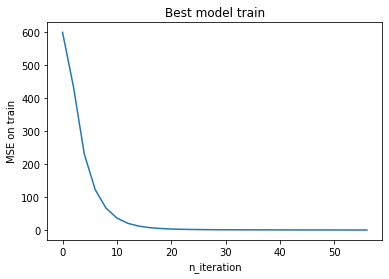

In [365]:
from matplotlib import pyplot as plt
plt.plot(np.arange(len(gb.errors))*2, gb.errors)
plt.xlabel("n_iteration")
plt.ylabel('MSE on train')
plt.title("Best model train")

### Задание 2. Сравнение подходов (1.5 балла)

Скачайте данные о выдаче кредитов. Это данные с kaggle, целевая переменная `y` показывает, вернуло ли кредит физическое лицо.

In [403]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [404]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6043,57,admin.,single,university.degree,no,no,yes,cellular,may,mon,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.354,5099.1,1
6251,30,services,single,high.school,unknown,yes,no,telephone,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,-1
8125,49,blue-collar,divorced,unknown,unknown,no,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,-1
8714,29,admin.,single,university.degree,no,no,yes,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,-1
6647,64,housemaid,married,unknown,no,yes,no,telephone,may,wed,...,3,999,0,nonexistent,-1.8,93.876,-40.0,0.697,5008.7,1


Решите задачу предсказания возвращения кредита методами, перечисленными ниже:

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

Используйте логистическую регрессию, случайный лес, `GradientBoostingClassifier` и `BaggingClassifier` из `sklearn`.

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается?


### Задание 3. Современные бустинги (1.5 балла)

Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost). Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев). Получилось ли круче, чем с моделями выше?

### Бонус (0.1 балла)

Прикрепите сюда что-нибудь для новогоднего настроения 👒

In [ ]:
# сюда